
# This is a time series forecasting using FB Prophet aiming to forecast upcoming confirmed and active cases of COVID-19 in worldwide and India.

#### note :

1. Dataset is till 28 may,2020.

2. Dataset is collected from https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/.  
      
3. This notebook acts as a template, in which you can forecast for any amount of time by loading to the latest dataset available. 

4. This is a demonstration of a Time Series Forecasting package called FB Prophet. For more details regarding fb prophet , do visit https://facebook.github.io/prophet/docs/quick_start.html

4. I am not a health professional or epidemiologist, and the analysis done in this notebook should not be interpreted as professional advice. For more information regarding the COVID-19 pandemic , follow W.H.O. and your respective countries' health department's guidelines.

## Importing Libraries

In [1]:
import pandas as pd
from fbprophet import Prophet

## Data Manipulation

In [5]:
# Loading Data Into The dataFrame df

df = pd.read_csv('https://raw.githubusercontent.com/sahilnishad/Forecasting_COVID-19_Cases_Using_FB_Prophet/master/covid_19_data.csv')

                                    Let's take a look into the dataset

In [6]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30883 entries, 0 to 30882
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              30883 non-null  int64  
 1   ObservationDate  30883 non-null  object 
 2   Province/State   15453 non-null  object 
 3   Country/Region   30883 non-null  object 
 4   Last Update      30883 non-null  object 
 5   Confirmed        30883 non-null  float64
 6   Deaths           30883 non-null  float64
 7   Recovered        30883 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.9+ MB


#####  Observations :

* as you can clearly see that the column 'Province/State' has majorly null values and serves no purpose here as we are going to forecast worldwide and India, and thus we are going to drop it.

* next thing you observe is that the 'ObservationDate' column is of object type and we require datetime type so that we can perform forecasting. So we are again going to load the data into the same dataframe, df, but this time we will use parse_dates on column 'ObservationDate'

#### Converting Type of 'ObservationDate' From Object To DateTime

In [8]:
df=pd.read_csv('https://raw.githubusercontent.com/sahilnishad/Forecasting_COVID-19_Cases_Using_FB_Prophet/master/covid_19_data.csv',parse_dates=['ObservationDate'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30883 entries, 0 to 30882
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SNo              30883 non-null  int64         
 1   ObservationDate  30883 non-null  datetime64[ns]
 2   Province/State   15453 non-null  object        
 3   Country/Region   30883 non-null  object        
 4   Last Update      30883 non-null  object        
 5   Confirmed        30883 non-null  float64       
 6   Deaths           30883 non-null  float64       
 7   Recovered        30883 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 1.9+ MB


'ObservationDate' is now of datetime type.

#### Dropping Columns

In [10]:
df.drop(['SNo','Province/State','Last Update'],axis=1,inplace=True)

# We don't require 'SNo' column because rows are already indexed 
# As 'Province/State' has so many null values and also our focus is primarily on country-wise
# 'Last Update' can be compensated by 'ObservationDate'

* "axis=1" means that we removing columns and not rows.
* "inplace" will replace old data with our newly modified data. 

#### Renaming columns 

In [11]:
df.rename(columns={'ObservationDate':'Date','Country/Region':'Country'},inplace=True)

# 'ObservationDate' is renamed as simply 'Date'
# 'Country/Region' is renamed as simply 'Country'

Till now all the editing in dataset is done. Let's see how our final data look like :

In [12]:
df.head()

,Date,Country,Confirmed,Deaths,Recovered
0,2020-01-22,Mainland China,1.0,0.0,0.0
1,2020-01-22,Mainland China,14.0,0.0,0.0
2,2020-01-22,Mainland China,6.0,0.0,0.0
3,2020-01-22,Mainland China,1.0,0.0,0.0
4,2020-01-22,Mainland China,0.0,0.0,0.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30883 entries, 0 to 30882
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       30883 non-null  datetime64[ns]
 1   Country    30883 non-null  object        
 2   Confirmed  30883 non-null  float64       
 3   Deaths     30883 non-null  float64       
 4   Recovered  30883 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.2+ MB


Looks minimalistic in terms of columns. But one thing here is missing. 

If you have guessed that a column of active case is missing then you are right. So next we'll include this also into our dataframe.

####  Including the 'Active' column 

n(active cases) = n(confirmed cases) - n(deaths) - n(recovered cases)

In [14]:
df['Active']=df['Confirmed']-df['Deaths']-df['Recovered']

Till here, our data manipulation to main dataframe is done. Let's take a look into the final dataset:

In [15]:
df.head()

,Date,Country,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Mainland China,1.0,0.0,0.0,1.0
1,2020-01-22,Mainland China,14.0,0.0,0.0,14.0
2,2020-01-22,Mainland China,6.0,0.0,0.0,6.0
3,2020-01-22,Mainland China,1.0,0.0,0.0,1.0
4,2020-01-22,Mainland China,0.0,0.0,0.0,0.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30883 entries, 0 to 30882
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       30883 non-null  datetime64[ns]
 1   Country    30883 non-null  object        
 2   Confirmed  30883 non-null  float64       
 3   Deaths     30883 non-null  float64       
 4   Recovered  30883 non-null  float64       
 5   Active     30883 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.4+ MB


##### Now , we are going to create 4 different dataframe :
1. world_confirmed
2. world_active
3. india_confirmed
4. india_active

each data frame above mentioned will be having only two columns : 
    1. Date
    2. Confirmed / Active

Not only  that , we will further have to rename these two columns such as 'Date' will be renamed to 'ds' and 'Confirmed' or 'Active' goes by the name 'y'.
Please refer to the documentation provided regarding the workings of fbprophet (https://facebook.github.io/prophet/docs/quick_start.html)

#### Creating world_confirmed dataframe

we need to group the enteries in 'Confirmed' column from the main dataframe df according to the dates

In [17]:
world_confirmed=df.groupby('Date')['Confirmed'].sum().reset_index()

In [18]:
world_confirmed

,Date,Confirmed
0,2020-01-22,555.0
1,2020-01-23,653.0
2,2020-01-24,941.0
3,2020-01-25,1438.0
4,2020-01-26,2118.0
...,...,...
123,2020-05-24,5407613.0
124,2020-05-25,5495061.0
125,2020-05-26,5589626.0
126,2020-05-27,5691790.0


#### Creating world_active dataframe

similar to what we did in world_confirmed, we are going to do it again. Only change is that we are grouping enteries in 'Active' column.

In [19]:
world_active=df.groupby('Date')['Active'].sum().reset_index()

In [20]:
world_active

,Date,Active
0,2020-01-22,510.0
1,2020-01-23,605.0
2,2020-01-24,879.0
3,2020-01-25,1357.0
4,2020-01-26,2010.0
...,...,...
123,2020-05-24,2893991.0
124,2020-05-25,2917091.0
125,2020-05-26,2952217.0
126,2020-05-27,2986073.0


#### Creating india_confirmed dataframe

Before proceeding to create 'india_confirmed' or even 'india_active', we must ensure that we are using country-specific data. But since the dataset we are using is included of all countries, so first we must filter out all such enteries in 'Country' column whenever 'India' is repeating.

In [21]:
india=df[df['Country']=='India']    

In [22]:
india

,Date,Country,Confirmed,Deaths,Recovered,Active
430,2020-01-30,India,1.0,0.0,0.0,1.0
491,2020-01-31,India,1.0,0.0,0.0,1.0
547,2020-02-01,India,1.0,0.0,0.0,1.0
607,2020-02-02,India,2.0,0.0,0.0,2.0
672,2020-02-03,India,3.0,0.0,0.0,3.0
...,...,...,...,...,...,...
28594,2020-05-24,India,138536.0,4024.0,57692.0,76820.0
29046,2020-05-25,India,144950.0,4172.0,60706.0,80072.0
29498,2020-05-26,India,150793.0,4344.0,64277.0,82172.0
29950,2020-05-27,India,158086.0,4534.0,67749.0,85803.0


now we can proceed as usual for creating 'india_confirmed'

In [23]:
india_confirmed=india.groupby('Date')['Confirmed'].sum().reset_index()

In [24]:
india_confirmed

,Date,Confirmed
0,2020-01-30,1.0
1,2020-01-31,1.0
2,2020-02-01,1.0
3,2020-02-02,2.0
4,2020-02-03,3.0
...,...,...
115,2020-05-24,138536.0
116,2020-05-25,144950.0
117,2020-05-26,150793.0
118,2020-05-27,158086.0


#### Creating india_active  dataframe

In [25]:
india_active=india.groupby('Date')['Active'].sum().reset_index()

In [26]:
india_active

,Date,Active
0,2020-01-30,1.0
1,2020-01-31,1.0
2,2020-02-01,1.0
3,2020-02-02,2.0
4,2020-02-03,3.0
...,...,...
115,2020-05-24,76820.0
116,2020-05-25,80072.0
117,2020-05-26,82172.0
118,2020-05-27,85803.0


___
    

# Forecasting 

    steps involved in forecating in each dataframes :
    1. renaming the columns
    2. building the model
    3. fitting the model
    4. creating dataframe for upcoming days
    5. forecasting
    6. plotting 
 ------

# Forecasting Confirmed Cases Worldwide

#### 1. Renaming the columns in world_confirmed 

In [27]:
world_confirmed.rename(columns={'Date':'ds','Confirmed':'y'},inplace=True)

In [28]:
world_confirmed

,ds,y
0,2020-01-22,555.0
1,2020-01-23,653.0
2,2020-01-24,941.0
3,2020-01-25,1438.0
4,2020-01-26,2118.0
...,...,...
123,2020-05-24,5407613.0
124,2020-05-25,5495061.0
125,2020-05-26,5589626.0
126,2020-05-27,5691790.0


#### 2. Building the model 

In [29]:
model_world_confirmed=Prophet(interval_width=0.95)

# interval_width means the confidence level. 0.95 implies that the model will try to forecast with an accuracy of 95%

#### 3. Fitting the model

In [30]:
model_world_confirmed.fit(world_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 4. Creating dataframe for upcoming days

In [32]:
future_world_confirmed=model_world_confirmed.make_future_dataframe(periods=33)

# in this step, we can determine for how many days we would like to forecast by setting the value of periods. 
# here, I am forecaasting for 33 days.

In [34]:
future_world_confirmed.tail(33)

# you can see that the dates for upcoming 33 days are created i.e. from 29 May to 30 June

,ds
128,2020-05-29
129,2020-05-30
130,2020-05-31
131,2020-06-01
132,2020-06-02
133,2020-06-03
134,2020-06-04
135,2020-06-05
136,2020-06-06
137,2020-06-07


#### 5. forecasting 

In [35]:
forecast_world_confirmed=model_world_confirmed.predict(future_world_confirmed)

In [36]:
forecast_world_confirmed

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-5.688140e+03,-3.637239e+04,1.540169e+04,-5.688140e+03,-5.688140e+03,-3976.986669,-3976.986669,-3976.986669,-3976.986669,-3976.986669,-3976.986669,0.0,0.0,0.0,-9.665127e+03
1,2020-01-23,-3.684797e+03,-2.965515e+04,2.529403e+04,-3.684797e+03,-3.684797e+03,417.559726,417.559726,417.559726,417.559726,417.559726,417.559726,0.0,0.0,0.0,-3.267237e+03
2,2020-01-24,-1.681454e+03,-2.486609e+04,2.981824e+04,-1.681454e+03,-1.681454e+03,2976.624753,2976.624753,2976.624753,2976.624753,2976.624753,2976.624753,0.0,0.0,0.0,1.295171e+03
3,2020-01-25,3.218894e+02,-2.303379e+04,3.359204e+04,3.218894e+02,3.218894e+02,5094.221138,5094.221138,5094.221138,5094.221138,5094.221138,5094.221138,0.0,0.0,0.0,5.416111e+03
4,2020-01-26,2.325233e+03,-2.135083e+04,3.092391e+04,2.325233e+03,2.325233e+03,2276.634111,2276.634111,2276.634111,2276.634111,2276.634111,2276.634111,0.0,0.0,0.0,4.601867e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2020-06-26,8.376508e+06,7.798024e+06,8.926390e+06,7.805016e+06,8.913473e+06,2976.624753,2976.624753,2976.624753,2976.624753,2976.624753,2976.624753,0.0,0.0,0.0,8.379484e+06
157,2020-06-27,8.467174e+06,7.859867e+06,9.049144e+06,7.864736e+06,9.035448e+06,5094.221138,5094.221138,5094.221138,5094.221138,5094.221138,5094.221138,0.0,0.0,0.0,8.472269e+06
158,2020-06-28,8.557841e+06,7.922120e+06,9.157437e+06,7.923322e+06,9.153442e+06,2276.634111,2276.634111,2276.634111,2276.634111,2276.634111,2276.634111,0.0,0.0,0.0,8.560118e+06
159,2020-06-29,8.648508e+06,7.974709e+06,9.273783e+06,7.982163e+06,9.263495e+06,-2054.078558,-2054.078558,-2054.078558,-2054.078558,-2054.078558,-2054.078558,0.0,0.0,0.0,8.646454e+06


In [37]:
# we need to focus on the columns 'ds','yhat','yhat_lower'and'yhat_upper'

forecast_world_confirmed[['ds','yhat','yhat_lower','yhat_upper']]

# yhat is the predicted value
# yhat_lower is the lower limit of yhat
# yhat_upper is the upper limit of yhat

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-9.665127e+03,-3.637239e+04,1.540169e+04
1,2020-01-23,-3.267237e+03,-2.965515e+04,2.529403e+04
2,2020-01-24,1.295171e+03,-2.486609e+04,2.981824e+04
3,2020-01-25,5.416111e+03,-2.303379e+04,3.359204e+04
4,2020-01-26,4.601867e+03,-2.135083e+04,3.092391e+04
...,...,...,...,...
156,2020-06-26,8.379484e+06,7.798024e+06,8.926390e+06
157,2020-06-27,8.472269e+06,7.859867e+06,9.049144e+06
158,2020-06-28,8.560118e+06,7.922120e+06,9.157437e+06
159,2020-06-29,8.646454e+06,7.974709e+06,9.273783e+06


-----------------------------------------------------------
|8.7 millions of confirmed cases worldwide by 30th June,2020|
-

#### 6. Plotting the confirmed cases worldwide 

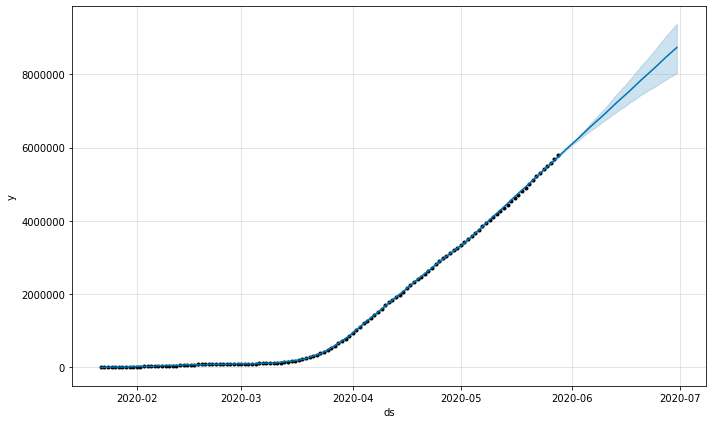

In [38]:
plot_world_confirmed=model_world_confirmed.plot(forecast_world_confirmed)

# black dots are actual present values
# blue line is the forecasted values

---
# Forecasting Active Cases Worldwide

#### 1. Renaming the columns in world_active 

In [39]:
world_active.rename(columns={'Date':'ds','Active':'y'},inplace=True)

In [40]:
world_active

,ds,y
0,2020-01-22,510.0
1,2020-01-23,605.0
2,2020-01-24,879.0
3,2020-01-25,1357.0
4,2020-01-26,2010.0
...,...,...
123,2020-05-24,2893991.0
124,2020-05-25,2917091.0
125,2020-05-26,2952217.0
126,2020-05-27,2986073.0


#### 2. Building the model

In [41]:
model_world_active=Prophet(interval_width=0.95)

# interval_width means the confidence level. 0.95 implies that the model will try to forecast with an accuracy of 95%

#### 3. Fitting the model

In [42]:
model_world_active.fit(world_active)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 4. Creating dataframe for upcoming days

In [43]:
future_world_active=model_world_active.make_future_dataframe(periods=33)

# in this step, we can determine for how many days we would like to forecast by setting the value of periods. 
# here, I am forecaasting for 33 days.

In [45]:
future_world_active

# you can see that the dates for upcoming 33 days are created (till 30 June)

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
...,...
156,2020-06-26
157,2020-06-27
158,2020-06-28
159,2020-06-29


#### 5. Forecasting

In [46]:
forecast_world_active=model_world_active.predict(future_world_active)

In [47]:
forecast_world_active

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-3.664509e+03,-2.465301e+04,9.624084e+03,-3.664509e+03,-3.664509e+03,-4599.733307,-4599.733307,-4599.733307,-4599.733307,-4599.733307,-4599.733307,0.0,0.0,0.0,-8.264243e+03
1,2020-01-23,-1.994120e+03,-2.057295e+04,1.244177e+04,-1.994120e+03,-1.994120e+03,-994.475802,-994.475802,-994.475802,-994.475802,-994.475802,-994.475802,0.0,0.0,0.0,-2.988596e+03
2,2020-01-24,-3.237306e+02,-1.549681e+04,1.715225e+04,-3.237306e+02,-3.237306e+02,1434.441918,1434.441918,1434.441918,1434.441918,1434.441918,1434.441918,0.0,0.0,0.0,1.110711e+03
3,2020-01-25,1.346659e+03,-1.322549e+04,2.015197e+04,1.346659e+03,1.346659e+03,3158.114904,3158.114904,3158.114904,3158.114904,3158.114904,3158.114904,0.0,0.0,0.0,4.504774e+03
4,2020-01-26,3.017048e+03,-1.048124e+04,2.300133e+04,3.017048e+03,3.017048e+03,2807.496804,2807.496804,2807.496804,2807.496804,2807.496804,2807.496804,0.0,0.0,0.0,5.824545e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2020-06-26,4.088280e+06,3.669213e+06,4.505093e+06,3.675949e+06,4.507974e+06,1434.441918,1434.441918,1434.441918,1434.441918,1434.441918,1434.441918,0.0,0.0,0.0,4.089715e+06
157,2020-06-27,4.124268e+06,3.696782e+06,4.567469e+06,3.696760e+06,4.558644e+06,3158.114904,3158.114904,3158.114904,3158.114904,3158.114904,3158.114904,0.0,0.0,0.0,4.127426e+06
158,2020-06-28,4.160256e+06,3.705542e+06,4.620333e+06,3.711653e+06,4.612556e+06,2807.496804,2807.496804,2807.496804,2807.496804,2807.496804,2807.496804,0.0,0.0,0.0,4.163064e+06
159,2020-06-29,4.196244e+06,3.718760e+06,4.662982e+06,3.711195e+06,4.670867e+06,117.417199,117.417199,117.417199,117.417199,117.417199,117.417199,0.0,0.0,0.0,4.196362e+06


In [48]:
# we need to focus on the columns 'ds','yhat','yhat_lower'and'yhat_upper'

forecast_world_active[['ds','yhat','yhat_lower','yhat_upper']]

# yhat is the predicted value
# yhat_lower is the lower limit of yhat
# yhat_upper is the upper limit of yhat

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-8.264243e+03,-2.465301e+04,9.624084e+03
1,2020-01-23,-2.988596e+03,-2.057295e+04,1.244177e+04
2,2020-01-24,1.110711e+03,-1.549681e+04,1.715225e+04
3,2020-01-25,4.504774e+03,-1.322549e+04,2.015197e+04
4,2020-01-26,5.824545e+03,-1.048124e+04,2.300133e+04
...,...,...,...,...
156,2020-06-26,4.089715e+06,3.669213e+06,4.505093e+06
157,2020-06-27,4.127426e+06,3.696782e+06,4.567469e+06
158,2020-06-28,4.163064e+06,3.705542e+06,4.620333e+06
159,2020-06-29,4.196362e+06,3.718760e+06,4.662982e+06


-----------------------------------------------------------
|4.2 millions of active cases worldwide by 30 June,2020|
-

#### 6. Plotting the active cases worldwide

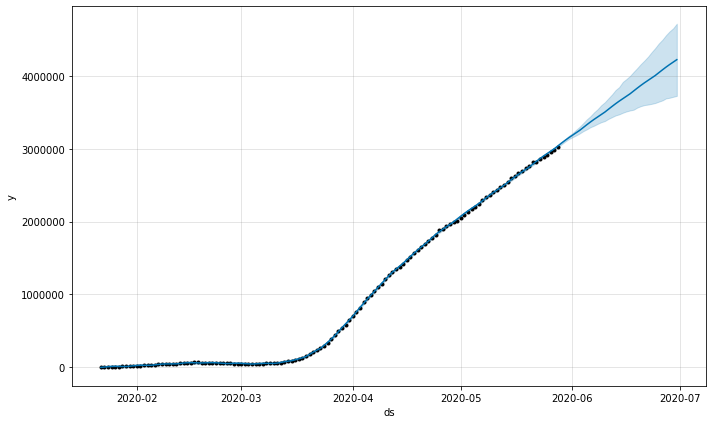

In [49]:
plot_world_active=model_world_active.plot(forecast_world_active)

# black dots are actual present values
# blue line is the forecasted values

---
# Forecasting Confirmed Cases In India

#### 1. Renaming the columns in india_confirmed

In [50]:
india_confirmed.rename(columns={'Date':'ds','Confirmed':'y'},inplace=True)

In [51]:
india_confirmed

,ds,y
0,2020-01-30,1.0
1,2020-01-31,1.0
2,2020-02-01,1.0
3,2020-02-02,2.0
4,2020-02-03,3.0
...,...,...
115,2020-05-24,138536.0
116,2020-05-25,144950.0
117,2020-05-26,150793.0
118,2020-05-27,158086.0


#### 2. Building the model

In [52]:
model_india_confirmed=Prophet(interval_width=0.95)

# interval_width means the confidence level. 0.95 implies that the model will try to forecast with an accuracy of 95%

#### 3. Fitting the model

In [53]:
model_india_confirmed.fit(india_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 4. Creating dataframe for upcoming days

In [54]:
future_india_confirmed=model_india_confirmed.make_future_dataframe(periods=33)

# in this step, we can determine for how many days we would like to forecast by setting the value of periods. 
# here, I am forecaasting for 33 days.

In [55]:
future_india_confirmed

# you can see that the dates for upcoming 33 days are created (till 30 June)

,ds
0,2020-01-30
1,2020-01-31
2,2020-02-01
3,2020-02-02
4,2020-02-03
...,...
148,2020-06-26
149,2020-06-27
150,2020-06-28
151,2020-06-29


#### 5. Forecasting

In [56]:
forecast_india_confirmed=model_india_confirmed.predict(future_india_confirmed)

In [57]:
forecast_india_confirmed

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-30,-214.793019,-4609.305320,5062.357459,-214.793019,-214.793019,337.558772,337.558772,337.558772,337.558772,337.558772,337.558772,0.0,0.0,0.0,122.765752
1,2020-01-31,-204.579238,-5475.951238,4546.501247,-204.579238,-204.579238,-363.413723,-363.413723,-363.413723,-363.413723,-363.413723,-363.413723,0.0,0.0,0.0,-567.992961
2,2020-02-01,-194.365457,-5257.263925,4194.056640,-194.365457,-194.365457,-280.804687,-280.804687,-280.804687,-280.804687,-280.804687,-280.804687,0.0,0.0,0.0,-475.170144
3,2020-02-02,-184.151675,-4964.270335,4621.027010,-184.151675,-184.151675,-81.496094,-81.496094,-81.496094,-81.496094,-81.496094,-81.496094,0.0,0.0,0.0,-265.647769
4,2020-02-03,-173.937894,-4918.589202,4583.473277,-173.937894,-173.937894,94.943357,94.943357,94.943357,94.943357,94.943357,94.943357,0.0,0.0,0.0,-78.994537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2020-06-26,289959.405466,267003.050119,311951.497484,267599.489919,311871.216010,-363.413723,-363.413723,-363.413723,-363.413723,-363.413723,-363.413723,0.0,0.0,0.0,289595.991743
149,2020-06-27,294654.922035,271876.549683,318221.472821,271259.072237,317259.620937,-280.804687,-280.804687,-280.804687,-280.804687,-280.804687,-280.804687,0.0,0.0,0.0,294374.117348
150,2020-06-28,299350.438604,275108.803695,323427.832697,274819.286917,323270.409529,-81.496094,-81.496094,-81.496094,-81.496094,-81.496094,-81.496094,0.0,0.0,0.0,299268.942510
151,2020-06-29,304045.955172,278639.910671,330033.194773,278376.578626,328955.052674,94.943357,94.943357,94.943357,94.943357,94.943357,94.943357,0.0,0.0,0.0,304140.898529


In [58]:
# we need to focus on the columns 'ds','yhat','yhat_lower'and'yhat_upper'

forecast_india_confirmed[['ds','yhat','yhat_lower','yhat_upper']]

# yhat is the predicted value
# yhat_lower is the lower limit of yhat
# yhat_upper is the upper limit of yhat

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-30,122.765752,-4609.305320,5062.357459
1,2020-01-31,-567.992961,-5475.951238,4546.501247
2,2020-02-01,-475.170144,-5257.263925,4194.056640
3,2020-02-02,-265.647769,-4964.270335,4621.027010
4,2020-02-03,-78.994537,-4918.589202,4583.473277
...,...,...,...,...
148,2020-06-26,289595.991743,267003.050119,311951.497484
149,2020-06-27,294374.117348,271876.549683,318221.472821
150,2020-06-28,299268.942510,275108.803695,323427.832697
151,2020-06-29,304140.898529,278639.910671,330033.194773


-----------------------------------------------------------
|308k of confirmed cases in India by 30 June,2020|
-

#### 6. Plotting the confirmed cases in India

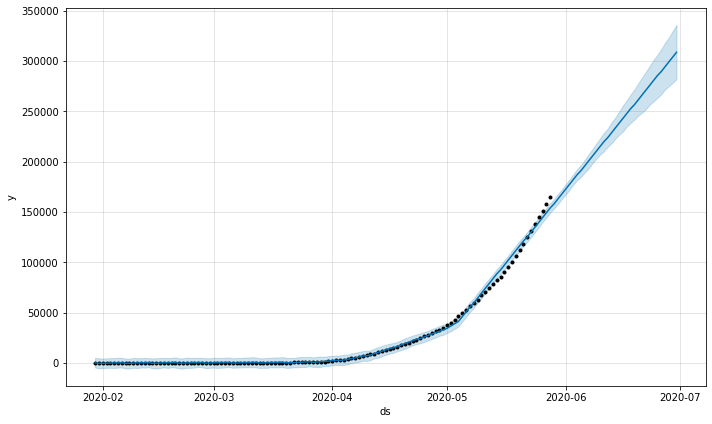

In [59]:
plot_india_confirmed=model_india_confirmed.plot(forecast_india_confirmed)

# black dots are actual present values
# blue line is the forecasted values

---
# Forecasting Active Cases In India

#### 1. Renaming the active in india_active

In [60]:
india_active.rename(columns={'Date':'ds','Active':'y'},inplace=True)

In [61]:
india_active

,ds,y
0,2020-01-30,1.0
1,2020-01-31,1.0
2,2020-02-01,1.0
3,2020-02-02,2.0
4,2020-02-03,3.0
...,...,...
115,2020-05-24,76820.0
116,2020-05-25,80072.0
117,2020-05-26,82172.0
118,2020-05-27,85803.0


#### 2. Building the model

In [62]:
model_india_active=Prophet(interval_width=0.95)

# interval_width means the confidence level. 0.95 implies that the model will try to forecast with an accuracy of 95%

#### 3. Fitting the model

In [63]:
model_india_active.fit(india_active)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### 4. Creating dataframe for upcoming days

In [64]:
future_india_active=model_india_active.make_future_dataframe(periods=33)

# in this step, we can determine for how many days we would like to forecast by setting the value of periods. 
# here, I am forecaasting for 33 days.

In [68]:
future_india_active

# you can see that the dates for upcoming 33 days are created (till 30 June)

,ds
0,2020-01-30
1,2020-01-31
2,2020-02-01
3,2020-02-02
4,2020-02-03
...,...
148,2020-06-26
149,2020-06-27
150,2020-06-28
151,2020-06-29


#### 5. Forecasting

In [69]:
forecast_india_active=model_india_active.predict(future_india_active)

In [70]:
forecast_india_active

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-30,-52.333784,-2003.235028,2184.720573,-52.333784,-52.333784,189.005004,189.005004,189.005004,189.005004,189.005004,189.005004,0.0,0.0,0.0,136.671220
1,2020-01-31,-49.829692,-2396.973641,1858.255223,-49.829692,-49.829692,-171.658103,-171.658103,-171.658103,-171.658103,-171.658103,-171.658103,0.0,0.0,0.0,-221.487794
2,2020-02-01,-47.325599,-2374.960627,1902.728438,-47.325599,-47.325599,-172.098337,-172.098337,-172.098337,-172.098337,-172.098337,-172.098337,0.0,0.0,0.0,-219.423936
3,2020-02-02,-44.821507,-2217.437104,1932.800053,-44.821507,-44.821507,-32.471997,-32.471997,-32.471997,-32.471997,-32.471997,-32.471997,0.0,0.0,0.0,-77.293504
4,2020-02-03,-42.317414,-1942.488413,2098.424932,-42.317414,-42.317414,86.733005,86.733005,86.733005,86.733005,86.733005,86.733005,0.0,0.0,0.0,44.415590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2020-06-26,149388.796334,137824.064525,159879.423501,137560.064145,159868.279934,-171.658103,-171.658103,-171.658103,-171.658103,-171.658103,-171.658103,0.0,0.0,0.0,149217.138231
149,2020-06-27,151639.686295,138964.379051,162114.778484,139387.733575,162573.741424,-172.098337,-172.098337,-172.098337,-172.098337,-172.098337,-172.098337,0.0,0.0,0.0,151467.587958
150,2020-06-28,153890.576257,140872.561339,165014.916576,141067.712598,165338.448886,-32.471997,-32.471997,-32.471997,-32.471997,-32.471997,-32.471997,0.0,0.0,0.0,153858.104260
151,2020-06-29,156141.466219,142590.256486,168528.082622,142918.461462,168181.694568,86.733005,86.733005,86.733005,86.733005,86.733005,86.733005,0.0,0.0,0.0,156228.199223


In [71]:
# we need to focus on the columns 'ds','yhat','yhat_lower'and'yhat_upper'

forecast_india_active[['ds','yhat','yhat_lower','yhat_upper']]

# yhat is the predicted value
# yhat_lower is the lower limit of yhat
# yhat_upper is the upper limit of yhat

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-30,136.671220,-2003.235028,2184.720573
1,2020-01-31,-221.487794,-2396.973641,1858.255223
2,2020-02-01,-219.423936,-2374.960627,1902.728438
3,2020-02-02,-77.293504,-2217.437104,1932.800053
4,2020-02-03,44.415590,-1942.488413,2098.424932
...,...,...,...,...
148,2020-06-26,149217.138231,137824.064525,159879.423501
149,2020-06-27,151467.587958,138964.379051,162114.778484
150,2020-06-28,153858.104260,140872.561339,165014.916576
151,2020-06-29,156228.199223,142590.256486,168528.082622


-----------------------------------------------------------
|158k of active cases in India by 30 June,2020|
-

#### 6. Plotting the active cases in India

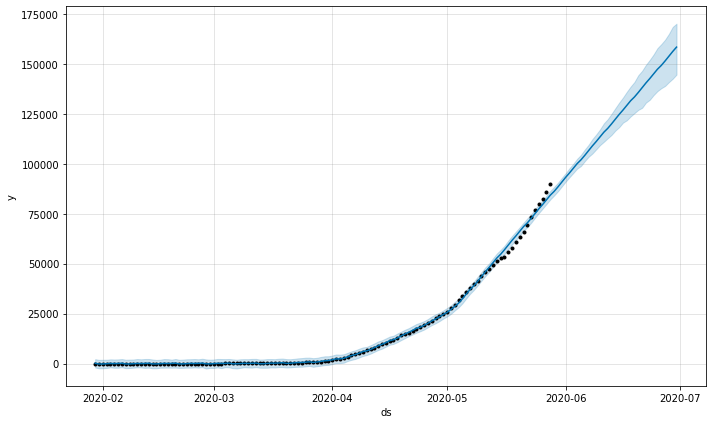

In [72]:
plot_india_active=model_india_active.plot(forecast_india_active)

# black dots are actual present values
# blue line is the forecasted values

---
---

# Conclusion: 
---
#  by the end of June, 2020 , there will be :

* 8.7 millions of confirmed cases worldwide 
* 4.2 millions of active cases worldwide 
* 308k of confirmed cases in India 
* 158k of active cases in India 